# Imports and Data Preparation

In [638]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit, cross_validate, validation_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LogisticRegression
#from sklearn.metrics import mean_squared_error
from IPython.display import Image

In [549]:
df = pd.read_csv("data_with_calc_fields.csv", sep=';', decimal=",")

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')
df = df.drop("date", axis=1)

# Add column with 24h max
df["solar_24h_max"] = df.solar_generation_actual.rolling(24,  min_periods=1).max()

# Calculate a moving average FOR EACH HOUR: MOV_AVG_Thur <-- AVG(Mon 1am, Tue 1am, Wed 1am, Thur 1am)
for i in range (24):
    df.loc[df.index.hour == i,"hourly_moving_avg"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(4,  min_periods=1).mean()

for i in range (24):
    df.loc[df.index.hour == i,"hourly_moving_avg_2"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(2,  min_periods=1).mean()

for i in range (24):
    df.loc[df.index.hour == i,"hourly_moving_avg_7"] = df.loc[df.index.hour == i,"solar_generation_actual"].rolling(7,  min_periods=1).mean()
    
# Add columns with forecast errors shiftet by one hour
df["solar_forecast_error_shifted"] = df.solar_forecast_error.shift(1)
df.loc["2016-01-01 00:00:00","solar_forecast_error_shifted"] = 0 # to avoid NaN value
df["wind_forecast_error_shifted"] = df.wind_forecast_error.shift(1)
df.loc["2016-01-01 00:00:00","wind_forecast_error_shifted"] = 0 # to avoid NaN value
df["price_difference_shifted"] = df.price_diff.shift(1)
df.loc["2016-01-01 00:00:00","price_difference_shifted"] = 0 # to avoid NaN value

In [550]:
df.head(3)

,hour,day_ahead_price,intraday_price,price_diff,solar_capacity,solar_generation_actual,wind_capacity,wind_generation_actual,wind_generation_forecast,solar_generation_forecast,...,season,month,weekday,solar_24h_max,hourly_moving_avg,hourly_moving_avg_2,hourly_moving_avg_7,solar_forecast_error_shifted,wind_forecast_error_shifted,price_difference_shifted
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0,23.86,29.34,5.48,39021,0,44325,8648,6033,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2016-01-01 01:00:00,1,22.39,24.28,1.89,39021,0,44325,8579,7421,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,2615.0,5.48
2016-01-01 02:00:00,2,20.59,25.26,4.67,39021,0,44325,8542,7266,0,...,0,1,4,0.0,0.0,0.0,0.0,0.0,1158.0,1.89


In [551]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17542 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 39 columns):
hour                               17542 non-null int64
day_ahead_price                    17542 non-null float64
intraday_price                     17542 non-null float64
price_diff                         17542 non-null float64
solar_capacity                     17542 non-null int64
solar_generation_actual            17542 non-null int64
wind_capacity                      17542 non-null int64
wind_generation_actual             17542 non-null int64
wind_generation_forecast           17542 non-null int64
solar_generation_forecast          17542 non-null int64
total_generation_forecast          17542 non-null int64
total_generation_actual            17542 non-null int64
wind_forecast_error                17542 non-null int64
solar_forecast_error               17542 non-null int64
forecast_error                     17542 non-null int64
wind_forec

# Testing different Prediction Methods

## Time Series Analysis

In [414]:
df_SG = df[["solar_generation_actual"]]

In [415]:
model = AR(df_SG)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [416]:
model_fit = model.fit()
yhat = model_fit.predict(len(df_SG), len(df_SG))
print(yhat)

17542    5.534279
dtype: float64


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [101]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(df_SG, order=(0, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(df_SG), len(df_SG))
print(yhat)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


17542    2130.752525
dtype: float64


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [115]:
df_VAR = df[["solar_generation_actual","solar_forecast_error"]]

# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# fit model
model = VAR(df_VAR)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[165.71293742  -5.06380007]]


## Classical Predictors

Classical Time Series Methods do not seem to be appropriate for our problem since most of them take a 1d array and search for trends. Instead different regression methods (which take several input variables) are used

In [552]:
# Set with which features the prediction should be made and with feature should be predicted
y = df.solar_forecast_error
X = df.drop(["solar_forecast_error",
             "solar_generation_actual",
             "wind_forecast_error_percent",
             "solar_forecast_error_percent","wind_capacity",
             "wind_generation_actual",
             "wind_generation_forecast",
             "wind_forecast_error",
             "pricediff_percent",
             "total_generation_forecast",
             "total_generation_actual",
             "forecast_error",
             "mov_avg_1_wind_forecast_error",
             "price_diff"], axis=1)
X = X.reset_index()
X = X.drop("datetime", axis=1)
X.info()
X.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17542 entries, 0 to 17541
Data columns (total 25 columns):
hour                               17542 non-null int64
day_ahead_price                    17542 non-null float64
intraday_price                     17542 non-null float64
solar_capacity                     17542 non-null int64
solar_generation_forecast          17542 non-null int64
mov_avg_30_forecast_error          17542 non-null float64
mov_avg_30_wind_forecast_error     17542 non-null float64
mov_avg_30_solar_forecast_error    17542 non-null float64
mov_avg_10_forecast_error          17542 non-null float64
mov_avg_10_wind_forecast_error     17542 non-null float64
mov_avg_10_solar_forecast_error    17542 non-null float64
mov_avg_1_forecast_error           17542 non-null float64
mov_avg_1_solar_forecast_error     17542 non-null float64
mov_avg_1_day_ahead                17542 non-null float64
mov_avg_1_intraday                 17542 non-null float64
season                     

,hour,day_ahead_price,intraday_price,solar_capacity,solar_generation_forecast,mov_avg_30_forecast_error,mov_avg_30_wind_forecast_error,mov_avg_30_solar_forecast_error,mov_avg_10_forecast_error,mov_avg_10_wind_forecast_error,...,season,month,weekday,solar_24h_max,hourly_moving_avg,hourly_moving_avg_2,hourly_moving_avg_7,solar_forecast_error_shifted,wind_forecast_error_shifted,price_difference_shifted
0,0,23.86,29.34,39021,0,2615.000000,2615.000000,0.0,2615.000000,2615.000000,...,0,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,1,22.39,24.28,39021,0,1885.488194,1885.488194,0.0,1883.464583,1883.464583,...,0,1,4,0.0,0.0,0.0,0.0,0.0,2615.0,5.48
2,2,20.59,25.26,39021,0,1681.760861,1681.760861,0.0,1679.286653,1679.286653,...,0,1,4,0.0,0.0,0.0,0.0,0.0,1158.0,1.89


In [596]:
# Create splitter for cross validation appropriate for time series data. This splitter will be handed over to cross_val_score()

tscv = TimeSeriesSplit(n_splits=7)

Regurlar cross-validation splits the whole dataset in k folds. In the k-th split it returns the k-th fold as the test set and the remaining folds as training set.
Here the dataset is split into 7 folds. In the k-th split it returns the first k folds as train set and the (k+1)th fold as test set. This has to be done because each data point in the time series depends on the previous ones. Due to the splitting, except for the last split not every fold is taken either as training or test split. Take a look at the follwing visualisation from scikit-learn:

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

In [613]:
# Test different depths of decision tree regressor

for i in range(3,11):
    DTR = DecisionTreeRegressor(max_depth=i)
    print(str(i)+": "+ str(-cross_val_score(DTR, X, y, cv=tscv, scoring="neg_mean_squared_error").mean()))
print("Done!")

3: 115621.14455426484
4: 90094.09760960199
5: 87702.30422016005
6: 89603.41211647233
7: 88484.29836367206
8: 96198.52421209964
9: 105431.27120594327
10: 112019.10677107528
Done!


In [606]:
# Test different depths of random forest regressor

for i in range(3,11):
    RFR = RandomForestRegressor(max_depth=i)
    print(str(i)+": "+ str(-cross_val_score(RFR, X, y, cv=tscv, scoring="neg_mean_squared_error").mean()))
print("Done!")

3: 101676.1462252948
4: 82064.11124263333
5: 75150.7541619065
6: 72674.38044657731
7: 70822.05605461572
8: 70867.21388805113
9: 75406.52987402836
10: 75322.11621095864
Done!


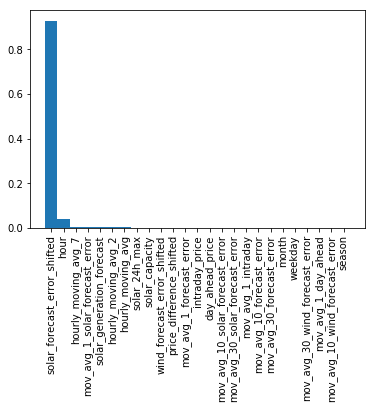

[(0.928, 'solar_forecast_error_shifted'),
 (0.04, 'hour'),
 (0.0056, 'hourly_moving_avg_7'),
 (0.0053, 'mov_avg_1_solar_forecast_error'),
 (0.0049, 'solar_generation_forecast'),
 (0.0032, 'hourly_moving_avg_2'),
 (0.0024, 'hourly_moving_avg'),
 (0.0011, 'solar_24h_max'),
 (0.0009, 'solar_capacity'),
 (0.0008, 'wind_forecast_error_shifted'),
 (0.0008, 'price_difference_shifted'),
 (0.0008, 'mov_avg_1_forecast_error'),
 (0.0008, 'intraday_price'),
 (0.0008, 'day_ahead_price'),
 (0.0007, 'mov_avg_10_solar_forecast_error'),
 (0.0006, 'mov_avg_30_solar_forecast_error'),
 (0.0006, 'mov_avg_1_intraday'),
 (0.0005, 'mov_avg_10_forecast_error'),
 (0.0004, 'mov_avg_30_forecast_error'),
 (0.0004, 'month'),
 (0.0003, 'weekday'),
 (0.0003, 'mov_avg_30_wind_forecast_error'),
 (0.0003, 'mov_avg_1_day_ahead'),
 (0.0003, 'mov_avg_10_wind_forecast_error'),
 (0.0001, 'season')]

In [637]:
# See how important the features of the data frame are for the prediction with Random Forests

RFR = RandomForestRegressor(max_depth=7)
RFR.fit(X,y)
features = sorted(zip(map(lambda x: round(x, 4), RFR.feature_importances_), X.columns), reverse=True)
#scores = cross_val_score(RFR, X, y, cv=tscv)
#print(scores.mean())
#print(scores.std())
#scores
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels, rotation='vertical')
plt.show()
features

The solar forcast error of the previous hour has the biggest impact on the prediction of the current solar forcast error.

In [607]:
RFR = RandomForestRegressor(max_depth=6)
cross_validate(RFR, X, y, cv=tscv.split(y), return_train_score=True, scoring="neg_mean_squared_error")

{'fit_time': array([0.13143229, 0.25328708, 0.40493202, 0.53305197, 0.767802  ,
        0.82181406, 0.94813299]),
 'score_time': array([0.00169396, 0.00169802, 0.00164199, 0.00170398, 0.00175285,
        0.00174069, 0.00187707]),
 'test_score': array([-143782.22433662,  -62010.47953752,  -36832.07974975,
         -58578.27849661,  -94396.47860407,  -73269.41739417,
         -25596.11492557]),
 'train_score': array([-27435.03213807, -49104.82249933, -50917.04139767, -46015.42931259,
        -47048.50990836, -52389.22656486, -55146.39556696])}

As you can see the estimator performs good on the training set and still quite good on the test set. 

In [587]:
# cross_val_predict only works for partitions

#RFR = RandomForestRegressor(max_depth=6)
#cross_val_predict(RFR, X, y, cv=tscv.split(y))

In [623]:
for alpha in (0.01, 0.1, 1.0, 10, 100, 1000, 1778, 3162, 5623, 10000, 31623, 100000, 1000000, 10000000, 100000000, 1000000000):
    RR = Ridge(alpha=alpha)
    print(str(alpha)+": "+ str(-cross_val_score(RR, X, y, cv=tscv, scoring="neg_mean_squared_error").mean()))
print("Done!")

0.01: 77955.84630116433
0.1: 77955.44898280468
1.0: 77951.50921205073
10: 77914.01482690811
100: 77572.70672216828
1000: 76602.35248791221
1778: 76496.16477914107
3162: 76469.18718000314
5623: 76479.92399322495
10000: 76500.35314150712
31623: 76553.5894476484
100000: 76608.49752490528
1000000: 76464.10594933534
10000000: 76594.50331543195
100000000: 79192.0560137451
1000000000: 121352.05906979405
Done!


In [562]:
ABR = AdaBoostRegressor(RandomForestRegressor(max_depth=6), n_estimators=12) # Default is with DecisionTreeRegressor(max_depth=3)
print(cross_val_score(ABR, X, y, cv=tscv).mean())

0.8519475017610024


Takes long and is not better than the RFR without AdaBoost, even with high number of estimators

In [579]:
GBR = GradientBoostingRegressor(max_depth=6) # Parameter max_features="sqrt" reduces variance, but also reduces CV score to 0.80
scores = cross_val_score(GBR, X, y, cv=tscv)
print(scores.mean())
print(scores.std())

0.8542693249306391
0.029562876221822975


In [578]:
BR = BaggingRegressor(RandomForestRegressor(max_depth=6)) # RandomForestRegressor(max_depth=6)
scores = cross_val_score(BR, X, y, cv=tscv)
print(scores.mean())
print(scores.std())

0.8574572482711751
0.027188311522937682


By now best result: High mean and low std

In [ ]:
# Multiclass
# Wenn man mehrere Target-Variablen hat, muss man sich überlegen, wie man damit umgehen möchte
# from sklearn.multiclass import OneVSRestClassifiert	liefert für jedes Attribut des Targets einen eigenen Classifier
# clf = OneVSRestClassifiert(LogisticRegression())

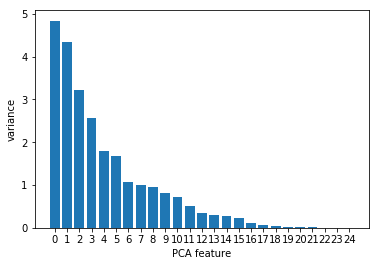

In [539]:
# PCA

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit_transform(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()